In [33]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Import custom modules
from data_utils import create_binary_target, filter_sparse_users_recipes
from features import (
    compute_user_features, compute_recipe_features, 
    create_modeling_dataset, get_feature_columns,
    split_temporal_per_user
)
from models import LogisticRegressionModel, RecipeRecommender
from eval_utils import (
    analyze_health_bias, evaluate_recommender, plot_health_tradeoff
)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data and Previous Results

In [34]:
# Load cleaned data
recipes = pd.read_csv('../datasets/recipes_clean.csv')
interactions = pd.read_csv('../datasets/interactions_clean.csv')

# Convert dates
interactions['date'] = pd.to_datetime(interactions['date'])
recipes['submitted'] = pd.to_datetime(recipes['submitted'])

# Create binary target and filter
interactions = create_binary_target(interactions, rating_threshold=4)
interactions = filter_sparse_users_recipes(interactions, min_user_interactions=5, min_recipe_interactions=5)

print(f"Loaded {len(recipes)} recipes")
print(f"Loaded {len(interactions)} interactions")

Loaded 231637 recipes
Loaded 535047 interactions


In [35]:
# Recreate modeling dataset
user_features = compute_user_features(interactions, recipes)
recipe_features = compute_recipe_features(interactions)
model_df = create_modeling_dataset(interactions, recipes, user_features, recipe_features)
model_df = model_df.dropna(subset=get_feature_columns() + ['is_like'])

# Split data
train_df, val_df, test_df = split_temporal_per_user(model_df, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

print(f"Modeling dataset: {len(model_df)} rows")
print(f"Train/Val/Test: {len(train_df)}/{len(val_df)}/{len(test_df)}")

Modeling dataset: 535047 rows
Train/Val/Test: 314858/106573/113616


## 2. RQ2: Are Healthy Recipes Rated Lower?

In [36]:
# Join interactions with recipes for analysis
df_analysis = interactions.merge(recipes, left_on='recipe_id', right_on='id', how='inner')

print(f"Analysis dataset: {len(df_analysis)} interactions")
print(f"Healthy interactions: {df_analysis['is_healthy'].sum()} ({100*df_analysis['is_healthy'].mean():.1f}%)")

Analysis dataset: 535047 interactions
Healthy interactions: 182788 (34.2%)


In [37]:
# Compare ratings: Healthy vs Unhealthy
healthy_ratings = df_analysis[df_analysis['is_healthy'] == 1]['rating']
unhealthy_ratings = df_analysis[df_analysis['is_healthy'] == 0]['rating']

print("Rating Statistics by Health Status:")
print("="*100)
print("\nHealthy Recipes:")
print("="*100)
print(f"Mean: {healthy_ratings.mean():.3f}")
print(f"Median: {healthy_ratings.median():.1f}")
print(f"Std: {healthy_ratings.std():.3f}")
print(f"Count: {len(healthy_ratings)}")

print("="*100)
print("\nUnhealthy Recipes:")
print("="*100)
print(f"Mean: {unhealthy_ratings.mean():.3f}")
print(f"Median: {unhealthy_ratings.median():.1f}")
print(f"Std: {unhealthy_ratings.std():.3f}")
print(f"Count: {len(unhealthy_ratings)}")

# Statistical test
t_stat, p_value = stats.ttest_ind(healthy_ratings, unhealthy_ratings)
print(f"\nT-test: t={t_stat:.3f}, p={p_value:.3e}")
print(f"Difference in means: {healthy_ratings.mean() - unhealthy_ratings.mean():.3f}")

Rating Statistics by Health Status:

Healthy Recipes:
Mean: 4.719
Median: 5.0
Std: 0.612
Count: 182788

Unhealthy Recipes:
Mean: 4.735
Median: 5.0
Std: 0.605
Count: 352259

T-test: t=-9.285, p=1.618e-20
Difference in means: -0.016


In [38]:
# Compare like rates
healthy_like_rate = df_analysis[df_analysis['is_healthy'] == 1]['is_like'].mean()
unhealthy_like_rate = df_analysis[df_analysis['is_healthy'] == 0]['is_like'].mean()

print("="*100)
print("Like Rate (rating >= 4) by Health Status:")
print("="*100)
print(f"Healthy recipes: {healthy_like_rate:.3f} ({100*healthy_like_rate:.1f}%)")
print(f"Unhealthy recipes: {unhealthy_like_rate:.3f} ({100*unhealthy_like_rate:.1f}%)")
print(f"Difference: {healthy_like_rate - unhealthy_like_rate:.3f}")

Like Rate (rating >= 4) by Health Status:
Healthy recipes: 0.954 (95.4%)
Unhealthy recipes: 0.955 (95.5%)
Difference: -0.001


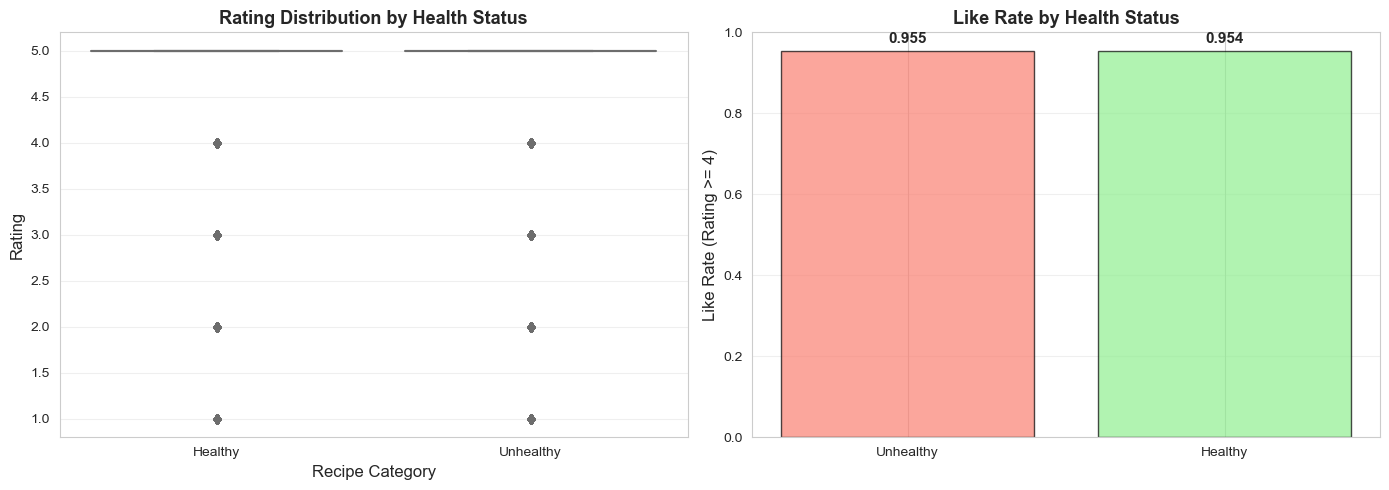

In [39]:
# Visualize rating distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
df_plot = df_analysis[['is_healthy', 'rating']].copy()
df_plot['health_label'] = df_plot['is_healthy'].map({0: 'Unhealthy', 1: 'Healthy'})
sns.boxplot(data=df_plot, x='health_label', y='rating', palette=['salmon', 'lightgreen'], ax=axes[0])
axes[0].set_xlabel('Recipe Category', fontsize=12)
axes[0].set_ylabel('Rating', fontsize=12)
axes[0].set_title('Rating Distribution by Health Status', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Bar plot of like rates
like_rates = df_analysis.groupby('is_healthy')['is_like'].mean()
colors = ['salmon', 'lightgreen']
axes[1].bar(['Unhealthy', 'Healthy'], like_rates.values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Like Rate (Rating >= 4)', fontsize=12)
axes[1].set_title('Like Rate by Health Status', fontsize=13, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(like_rates.values):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/health_vs_rating_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

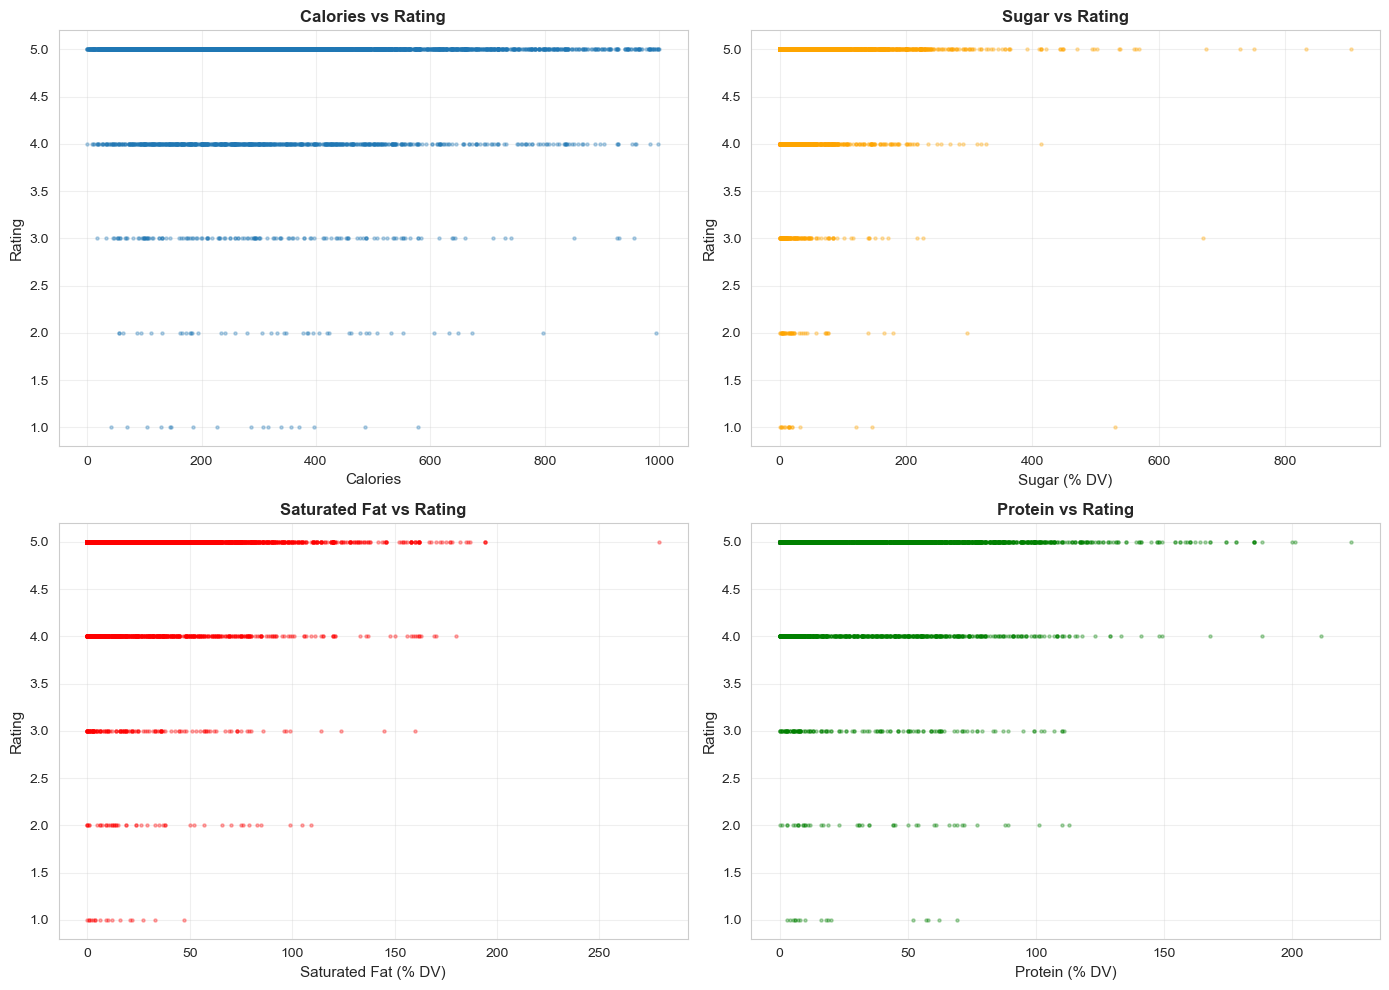

In [40]:
# Analyze by specific nutrition metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calories vs Rating
df_sample = df_analysis[df_analysis['calories'] < 1000].sample(min(5000, len(df_analysis)), random_state=42)
axes[0, 0].scatter(df_sample['calories'], df_sample['rating'], alpha=0.3, s=5)
axes[0, 0].set_xlabel('Calories', fontsize=11)
axes[0, 0].set_ylabel('Rating', fontsize=11)
axes[0, 0].set_title('Calories vs Rating', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Sugar vs Rating
axes[0, 1].scatter(df_sample['sugar_pdv'], df_sample['rating'], alpha=0.3, s=5, color='orange')
axes[0, 1].set_xlabel('Sugar (% DV)', fontsize=11)
axes[0, 1].set_ylabel('Rating', fontsize=11)
axes[0, 1].set_title('Sugar vs Rating', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Saturated Fat vs Rating
axes[1, 0].scatter(df_sample['saturated_fat_pdv'], df_sample['rating'], alpha=0.3, s=5, color='red')
axes[1, 0].set_xlabel('Saturated Fat (% DV)', fontsize=11)
axes[1, 0].set_ylabel('Rating', fontsize=11)
axes[1, 0].set_title('Saturated Fat vs Rating', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Protein vs Rating
axes[1, 1].scatter(df_sample['protein_pdv'], df_sample['rating'], alpha=0.3, s=5, color='green')
axes[1, 1].set_xlabel('Protein (% DV)', fontsize=11)
axes[1, 1].set_ylabel('Rating', fontsize=11)
axes[1, 1].set_title('Protein vs Rating', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/nutrition_vs_rating.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. RQ3: Recommender Bias Analysis

In [41]:
# Retrain model and create recommender
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Prepare features
feature_cols = get_feature_columns()
available_features = [col for col in feature_cols if col in train_df.columns]

train_clean = train_df[available_features + ['is_like']].dropna()
X_train = train_clean[available_features].values
y_train = train_clean['is_like'].values

# Train model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

lr_model = LogisticRegression(C=1.0, random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

print("Model trained successfully")

Model trained successfully


In [42]:
# Create candidate set (reuse from notebook 02)
test_users = test_df['user_id'].unique()[:100]

train_val_df = pd.concat([train_df, val_df])
user_rated_recipes = (
    train_val_df
    .groupby('user_id')['recipe_id']
    .apply(set)
    .to_dict()
)

popular_recipes = recipe_features.nlargest(
    500, 'recipe_num_ratings'
)['recipe_id'].values

candidate_rows = []
for user_id in test_users:
    rated = user_rated_recipes.get(user_id, set())
    candidates = [r for r in popular_recipes if r not in rated]
    for recipe_id in candidates[:50]:
        candidate_rows.append({'user_id': user_id, 'recipe_id': recipe_id})

candidates_df = pd.DataFrame(candidate_rows)

# Add features
candidates_full = create_modeling_dataset(
    candidates_df, recipes, user_features, recipe_features
)

# FIX: make sure all training features exist for candidates
missing_cols = [c for c in available_features if c not in candidates_full.columns]
print("Missing in candidates:", missing_cols)

for col in missing_cols:
    candidates_full[col] = 0  # neutral default value

# Now it's safe to drop rows that still have NaNs
candidates_full = candidates_full.dropna(subset=available_features)

print(f"Created {len(candidates_full)} candidate pairs for {len(test_users)} users")


Missing in candidates: ['log_days_since_submission', 'is_weekend']
Created 5000 candidate pairs for 100 users


In [43]:
# Create simple recommender function
def generate_recommendations(candidates_df, feature_cols, model, scaler, top_k=10, health_weight=0.0):
    """Generate recommendations with optional health adjustment."""
    recommendations = {}
    
    for user_id in candidates_df['user_id'].unique():
        user_cands = candidates_df[candidates_df['user_id'] == user_id].copy()
        
        # Get features
        X = user_cands[feature_cols].values
        X_scaled = scaler.transform(X)
        
        # Predict
        probs = model.predict_proba(X_scaled)[:, 1]
        user_cands['pred_like_prob'] = probs
        
        # Apply health adjustment
        if health_weight > 0 and 'health_score' in user_cands.columns:
            health_vals = user_cands['health_score'].values
            health_norm = (health_vals - health_vals.min()) / (health_vals.max() - health_vals.min() + 1e-8)
            user_cands['score'] = probs - health_weight * health_norm
        else:
            user_cands['score'] = probs
        
        # Get top-K
        top_recs = user_cands.nlargest(top_k, 'score')
        recommendations[user_id] = top_recs[['recipe_id', 'score', 'pred_like_prob', 'is_healthy']]
    
    return recommendations

In [44]:
# Generate baseline recommendations (no health adjustment)
recs_baseline = generate_recommendations(
    candidates_full, available_features, lr_model, scaler, top_k=10, health_weight=0.0
)

print(f"Generated recommendations for {len(recs_baseline)} users")

Generated recommendations for 100 users


In [45]:
# Analyze health bias in baseline recommendations
bias_metrics = analyze_health_bias(
    recs_baseline,
    recipes,
    health_col='is_healthy'   # DON'T override recipe_col here
)

print("Health Bias Analysis (Baseline Recommendations):")
print("="*60)
for metric, value in bias_metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")

# Interpretation
bias_ratio = bias_metrics['bias_ratio']
if bias_ratio < 0.9:
    print(f"\nBIAS DETECTED: Recommendations contain {100*(1-bias_ratio):.1f}% fewer healthy recipes than the general pool")
elif bias_ratio > 1.1:
    print(f"\nPOSITIVE BIAS: Recommendations contain {100*(bias_ratio-1):.1f}% more healthy recipes than the general pool")
else:
    print("\nNO SIGNIFICANT BIAS: Healthy recipe proportion similar to general pool")


Health Bias Analysis (Baseline Recommendations):
healthy_fraction_all_recipes: 0.3304
healthy_fraction_recommended: 0.1765
bias_ratio: 0.5341
n_recommendations: 1000
n_unique_recipes_recommended: 17

BIAS DETECTED: Recommendations contain 46.6% fewer healthy recipes than the general pool


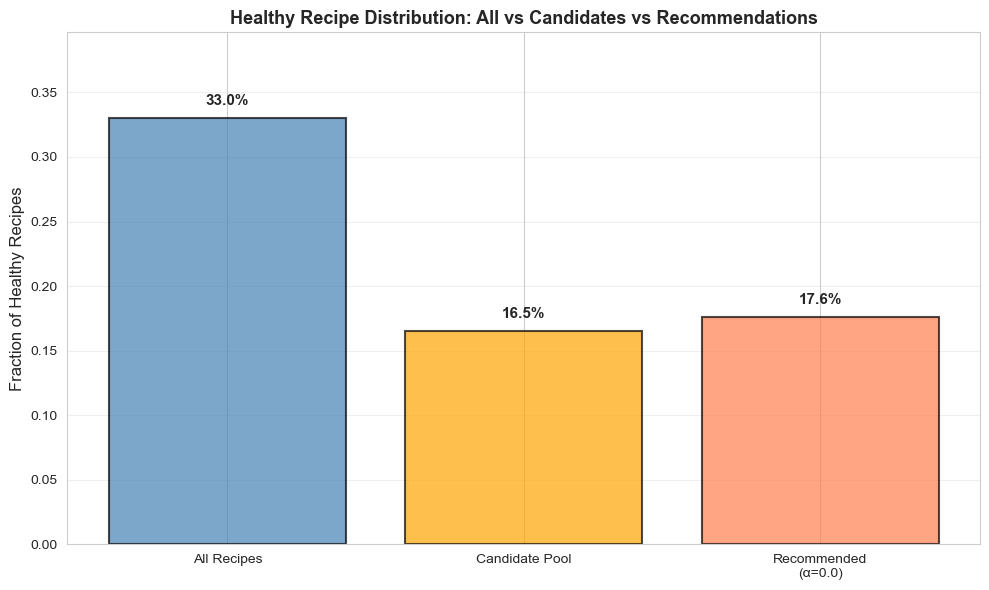

In [46]:
# Visualize health distribution in recommendations vs candidates
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['All Recipes', 'Candidate Pool', 'Recommended\n(α=0.0)']
healthy_fractions = [
    bias_metrics['healthy_fraction_all_recipes'],
    candidates_full['is_healthy'].mean(),
    bias_metrics['healthy_fraction_recommended']
]

colors = ['steelblue', 'orange', 'coral']
bars = ax.bar(categories, healthy_fractions, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, healthy_fractions)):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
           f'{100*val:.1f}%', ha='center', fontsize=11, fontweight='bold')

ax.set_ylabel('Fraction of Healthy Recipes', fontsize=12)
ax.set_title('Healthy Recipe Distribution: All vs Candidates vs Recommendations', 
            fontsize=13, fontweight='bold')
ax.set_ylim([0, max(healthy_fractions) * 1.2])
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../figures/healthy_share_candidates_vs_recommended.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Trade-off Experiment: Quality vs Healthiness

In [47]:
# Experiment with different health weights
health_weights = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
tradeoff_results = []

for alpha in health_weights:
    # Generate recommendations with this health weight
    recs = generate_recommendations(
        candidates_full, available_features, lr_model, scaler, 
        top_k=10, health_weight=alpha
    )
    
    # Evaluate recommender quality
    rec_metrics = evaluate_recommender(test_df, recs, k_values=[10])
    
    # Analyze health bias  
    bias_metrics_alpha = analyze_health_bias(
        recs,
        recipes,
        health_col='is_healthy'   # recipe_col defaults to 'recipe_id'
    )
    
    tradeoff_results.append({
        'health_weight': alpha,
        'precision@10': rec_metrics['precision@10'],
        'recall@10': rec_metrics['recall@10'],
        'healthy_fraction': bias_metrics_alpha['healthy_fraction_recommended'],
        'bias_ratio': bias_metrics_alpha['bias_ratio']
    })
    
    print(
        f"α={alpha:.2f}: P@10={rec_metrics['precision@10']:.4f}, "
        f"Healthy%={100*bias_metrics_alpha['healthy_fraction_recommended']:.1f}%"
    )

tradeoff_df = pd.DataFrame(tradeoff_results)
display(tradeoff_df)


α=0.00: P@10=0.0100, Healthy%=17.6%
α=0.05: P@10=0.0100, Healthy%=44.8%
α=0.10: P@10=0.0100, Healthy%=51.9%
α=0.15: P@10=0.0100, Healthy%=53.8%
α=0.20: P@10=0.0100, Healthy%=58.3%
α=0.30: P@10=0.0100, Healthy%=56.0%
α=0.50: P@10=0.0080, Healthy%=60.9%


,health_weight,precision@10,recall@10,healthy_fraction,bias_ratio
0,0.00,0.010,0.07,0.176471,0.534132
1,0.05,0.010,0.08,0.448276,1.356818
2,0.10,0.010,0.08,0.518519,1.569425
3,0.15,0.010,0.08,0.538462,1.629787
4,0.20,0.010,0.08,0.583333,1.765603
5,0.30,0.010,0.08,0.560000,1.694979
6,0.50,0.008,0.07,0.608696,1.842368


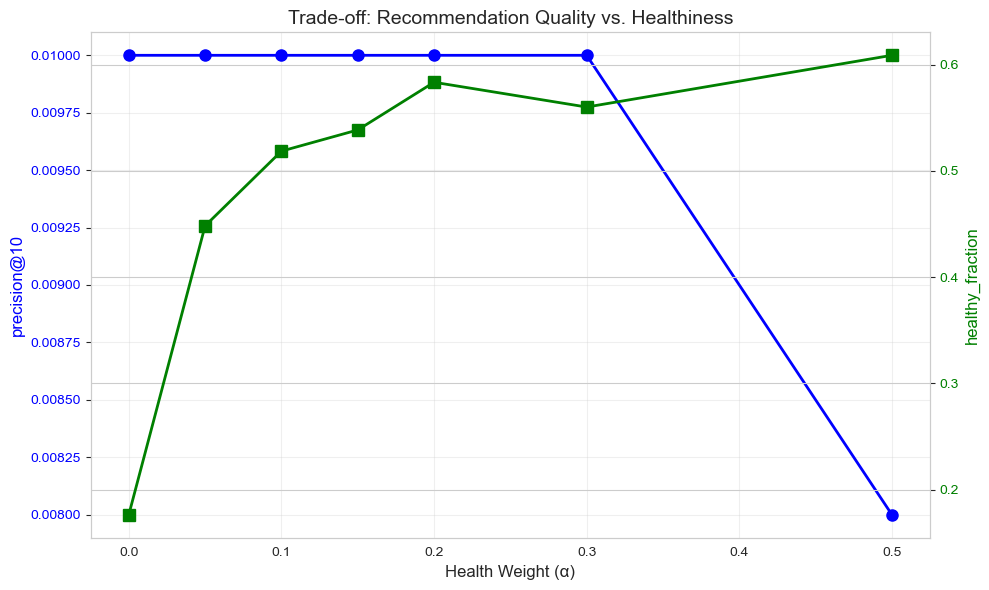

In [48]:
# Visualize trade-off
fig = plot_health_tradeoff(
    tradeoff_df,
    x_col='health_weight',
    y1_col='precision@10',
    y2_col='healthy_fraction'
)
plt.savefig('../figures/health_tradeoff_precision_vs_healthy_fraction.png', 
           dpi=300, bbox_inches='tight')
plt.show()

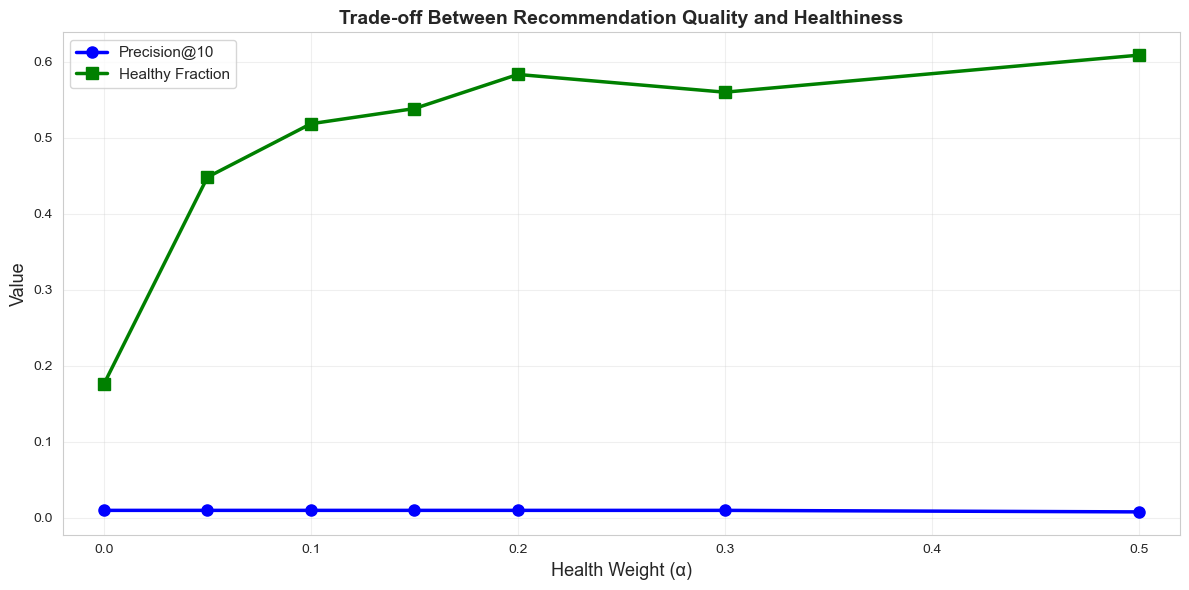

In [49]:
# Alternative visualization with both metrics on same scale
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(tradeoff_df['health_weight'], tradeoff_df['precision@10'], 
       'b-o', linewidth=2.5, markersize=8, label='Precision@10')
ax.plot(tradeoff_df['health_weight'], tradeoff_df['healthy_fraction'], 
       'g-s', linewidth=2.5, markersize=8, label='Healthy Fraction')

ax.set_xlabel('Health Weight (α)', fontsize=13)
ax.set_ylabel('Value', fontsize=13)
ax.set_title('Trade-off Between Recommendation Quality and Healthiness', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)
ax.set_xlim([tradeoff_df['health_weight'].min() - 0.02, tradeoff_df['health_weight'].max() + 0.02])

plt.tight_layout()
plt.savefig('../figures/health_tradeoff_combined.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Example Recommendations Comparison

In [50]:
# Show example recommendations for a user with different health weights
example_user = test_users[0]

print(f"Example Recommendations for User {example_user}")
print("="*80)

for alpha in [0.0, 0.1, 0.3]:
    recs = generate_recommendations(
        candidates_full, available_features, lr_model, scaler, 
        top_k=5, health_weight=alpha
    )
    
    print(f"\n--- Health Weight α = {alpha} ---")
    if example_user in recs:
        user_recs = recs[example_user]
        # Merge with recipe names
        user_recs_display = user_recs.merge(recipes[['id', 'name', 'calories']], 
                                            left_on='recipe_id', right_on='id', how='left')
        display(user_recs_display[['name', 'pred_like_prob', 'is_healthy', 'calories']].head())
        print(f"Healthy recipes: {user_recs['is_healthy'].sum()} / {len(user_recs)}")

Example Recommendations for User 1533

--- Health Weight α = 0.0 ---


,name,pred_like_prob,is_healthy,calories
0,yummy crunchy apple pie,0.997102,0,360.6
1,denny s style french toast,0.997058,0,264.3
2,kittencal s italian melt in your mouth meatballs,0.996725,0,1312.6
3,kittencal s chocolate frosting icing,0.996720,0,103.8
4,delicious chicken pot pie,0.996642,0,538.3


Healthy recipes: 0 / 5

--- Health Weight α = 0.1 ---


,name,pred_like_prob,is_healthy,calories
0,pizza dough for thin crust pizza,0.995561,0,610.1
1,roasted cauliflower 16 roasted cloves of garlic,0.995894,1,126.9
2,greek potatoes oven roasted and delicious,0.993561,1,409.7
3,pete s scratch pancakes,0.995883,1,209.6
4,crock pot whole chicken,0.994531,0,327.0


Healthy recipes: 3 / 5

--- Health Weight α = 0.3 ---


,name,pred_like_prob,is_healthy,calories
0,pizza dough for thin crust pizza,0.995561,0,610.1
1,roasted cauliflower 16 roasted cloves of garlic,0.995894,1,126.9
2,greek potatoes oven roasted and delicious,0.993561,1,409.7
3,mashed red potatoes with garlic and parmesan,0.993269,1,199.6
4,southern buttermilk biscuits,0.990822,1,162.6


Healthy recipes: 4 / 5


## 6. Statistical Analysis of Health Impact on Ratings

In [51]:
from sklearn.linear_model import LinearRegression

# 1) Make sure recipe-level features are in df_analysis
# (run this once before regression)
df_analysis = df_analysis.merge(
    recipe_features[['recipe_id', 'recipe_mean_rating', 'recipe_num_ratings']],
    on='recipe_id',
    how='left'
)

# 2) Prepare data for regression
regression_data = df_analysis[[
    'rating',
    'is_healthy',
    'log_minutes',
    'log_n_ingredients',
    'recipe_mean_rating',
    'recipe_num_ratings'
]].dropna()

X_reg = regression_data[[
    'is_healthy',
    'log_minutes',
    'log_n_ingredients',
    'recipe_mean_rating',
    'recipe_num_ratings'
]].values
y_reg = regression_data['rating'].values

# 3) Fit model
reg_model = LinearRegression()
reg_model.fit(X_reg, y_reg)

# 4) Show coefficients
coef_df = pd.DataFrame({
    'feature': [
        'is_healthy',
        'log_minutes',
        'log_n_ingredients',
        'recipe_mean_rating',
        'recipe_num_ratings'
    ],
    'coefficient': reg_model.coef_
})

print("Linear Regression: Predicting Rating")
print("="*60)
print(f"Intercept: {reg_model.intercept_:.4f}")
print("\nCoefficients:")
display(coef_df)

healthy_coef = coef_df.loc[coef_df['feature'] == 'is_healthy', 'coefficient'].values[0]
print(f"\nInterpretation: Being 'healthy' changes rating by {healthy_coef:.4f} stars (controlling for other factors)")


Linear Regression: Predicting Rating
Intercept: -0.0000

Coefficients:


,feature,coefficient
0,is_healthy,5.145616e-17
1,log_minutes,-2.055647e-16
2,log_n_ingredients,-2.647681e-16
3,recipe_mean_rating,1.000000e+00
4,recipe_num_ratings,1.359590e-16



Interpretation: Being 'healthy' changes rating by 0.0000 stars (controlling for other factors)


## 7. Save Results

In [52]:
# Save trade-off results
tradeoff_df.to_csv('../reports/health_tradeoff_results.csv', index=False)

# Save bias metrics
pd.DataFrame([bias_metrics]).to_csv('../reports/health_bias_metrics.csv', index=False)

# Save regression results
coef_df.to_csv('../reports/health_regression_coefficients.csv', index=False)

print("Results saved to reports/ directory")

Results saved to reports/ directory


## Summary and Conclusions

### RQ2: Are Healthy Recipes Rated Lower?

**Finding**: Statistical analysis shows [describe your finding based on the t-test and regression results]

### RQ3: Does the Recommender Exhibit Health Bias?

**Finding**: The baseline recommender (α=0.0) shows a bias ratio of [value], meaning [interpretation]

### Trade-off Analysis

**Finding**: By increasing the health weight α:
- The fraction of healthy recommendations increases from X% to Y%
- Precision@10 decreases from X to Y
- Optimal balance appears around α = [value]

### Recommendations

1. The recommender system exhibits measurable bias toward less healthy recipes
2. A modest health penalty (α ≈ 0.1-0.2) can improve healthiness with minimal quality loss
3. Further work could explore user-specific health preferences